In [1]:
import os
from DUAO.src import calibration, photometry, utils
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter

# Data reduction

In [2]:
asteroids_dir = os.path.join(utils.C2PU_DATA_DIR, utils.DIR_PHOTOM, utils.DIR_ASTER)
asteroids_dir = os.path.join(asteroids_dir, os.listdir(asteroids_dir)[0])
sorted(os.listdir(asteroids_dir))

['9-Metis_20231115T011656474_SC__0000s300_000000.fits',
 '9-Metis_20231115T011759878_SC__0000s300_000000.fits',
 '9-Metis_20231115T011903081_SC__0000s300_000000.fits',
 '9-Metis_20231115T012006353_SC__0000s300_000000.fits',
 '9-Metis_20231115T012109648_SC__0000s300_000000.fits',
 '9-Metis_20231115T012212965_SC__0000s300_000000.fits',
 '9-Metis_20231115T012316288_SC__0000s300_000000.fits',
 '9-Metis_20231115T012419613_SC__0000s300_000000.fits',
 '9-Metis_20231115T012522968_SC__0000s300_000000.fits',
 '9-Metis_20231115T012626292_SC__0000s300_000000.fits',
 '9-Metis_20231115T012729496_SC__0000s300_000000.fits',
 '9-Metis_20231115T012832746_SC__0000s300_000000.fits',
 '9-Metis_20231115T012936057_SC__0000s300_000000.fits',
 '9-Metis_20231115T013039365_SC__0000s300_000000.fits',
 '9-Metis_20231115T013142669_SC__0000s300_000000.fits',
 '9-Metis_20231115T013245916_SC__0000s300_000000.fits',
 '9-Metis_20231115T013349126_SC__0000s300_000000.fits',
 '9-Metis_20231115T013452313_SC__0000s300_000000

In [3]:
fits_sci_image = os.path.join(asteroids_dir, sorted(os.listdir(asteroids_dir))[0])
fits_sci_image = os.path.abspath(fits_sci_image)
os.path.isfile(fits_sci_image)

True

In [4]:
calibration.get_infos_from_image(fits_sci_image)

SCIENCE (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T01:16:56+00:00 (0.3s exposure).


(datetime.datetime(2023, 11, 15, 1, 16, 56, tzinfo=datetime.timezone.utc),
 'C2PU/Omicron',
 'QHY600M',
 '',
 0.3,
 4800,
 3211)

In [5]:
bias_dir, darks_dir, flats_dir = utils.get_calib_dirs_photometry(fits_sci_image)
print(bias_dir, darks_dir, flats_dir)

/home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/BIAS/QHY600 /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/DARKS/QHY600/0.3s /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/FLATS/QHY600/Filtre_None


In [6]:
# Get image directory, failename and extension
sc_im_dir = os.path.abspath(os.path.dirname(fits_sci_image))
sc_im_name, sc_im_ext = os.path.splitext(os.path.basename(fits_sci_image))
print(sc_im_dir, sc_im_name, sc_im_ext)

/home/etudiant/Documents/Archives_C2PU/Photometry/Asteroids/2023-11-14_OMICRON_F3p17_OPF_QHY600Ma_9-Metis 9-Metis_20231115T011656474_SC__0000s300_000000 .fits


In [7]:
# Get information from FITS header
sc_date, sc_scope, sc_cam, sc_filter, sc_expos, sc_x, sc_y = calibration.get_infos_from_image(fits_sci_image)

SCIENCE (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T01:16:56+00:00 (0.3s exposure).


In [8]:
bias_list = calibration.load_bias_frames(bias_dir, sc_date, sc_cam, sc_x, sc_y)
print(bias_list)
MASTER_BIAS  = calibration.master_bias(bias_list)

BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-20T22:39:22+00:00 (0.0s exposure).
5 days, 21:22:26
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-08-30T22:44:08+00:00 (0.0s exposure).
-807 days, 21:27:12
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-21T00:33:00+00:00 (0.0s exposure).
5 days, 23:16:04
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-20T22:39:25+00:00 (0.0s exposure).
5 days, 21:22:29
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-21T00:32:41+00:00 (0.0s exposure).
5 days, 23:15:45
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-20T22:39:31+00:00 (0.0s exposure).
5 days, 21:22:35
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-21T00:32:57+00:00 (0.0s exposure).
5 days, 23:16:01
BIAS (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-08-30T22:44:17+00:00 (0.0s exposure).
-807 days, 21:27:21
BI

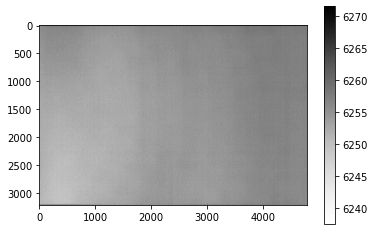

In [9]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(MASTER_BIAS["data"], sigma=3.0)

plt.imshow(MASTER_BIAS["data"], cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [10]:
# Master dark
# TBD: check if there is already one that works
darks_list = calibration.load_dark_frames(darks_dir, sc_date, sc_cam, sc_expos, sc_x, sc_y)

DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:12+00:00 (0.3s exposure).
-761 days, 16:01:16
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:41+00:00 (0.3s exposure).
1:29:45
DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:05+00:00 (0.3s exposure).
-761 days, 16:01:09
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:17+00:00 (0.3s exposure).
1:29:21
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:32+00:00 (0.3s exposure).
1:29:36
DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:35+00:00 (0.3s exposure).
1:29:39
DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:18+00:00 (0.3s exposure).
-761 days, 16:01:22
DARK (4800x3211) taken in band SDSSgp+ with QHY600M on C2PU/Omicron on 2021-10-15T17:18:08+00:00 (0.3s exposure).
-761 days, 16:01:12
DARK

In [11]:
MASTER_DARK, HOT_PIXELS = calibration.master_dark(darks_list, use_bias=False, master_bias=MASTER_BIAS['path'])

DARK (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2023-11-15T02:46:41+00:00 (0.3s exposure).
Number of pixels in the dark: 15412800
Number of hot pixels       :    10181
Fraction of hot pixels (%) : 0.07
Master DARK written to /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/DARKS/QHY600/0.3s/MASTER_DARKS/master_dark_2023-11-15_QHY600M_0.300.fits.
Hot pixels map written to /home/etudiant/Documents/Archives_C2PU/Photometry/CCD__BIAS_DARKS_FLATS/DARKS/QHY600/0.3s/MASTER_DARKS/bad_pixels_hot_2023-11-15_QHY600M.fits.


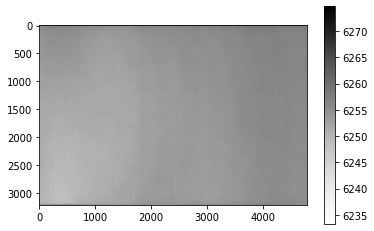

In [12]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(MASTER_DARK["data"], sigma=3.0)

plt.imshow(MASTER_DARK["data"], cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [13]:
# Master flat
# TBD: check if there is already one that works
flats_list = calibration.load_flat_frames(flats_dir, sc_date, sc_cam, sc_filter, sc_x, sc_y,\
                                          override_date_check=True)
MASTER_FLAT, DEAD_PIXELS = calibration.master_flat(flats_list, MASTER_DARK["path"])

FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:30:13+00:00 (0.1s exposure).
-848 days, 18:13:17
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:39+00:00 (0.1s exposure).
-848 days, 18:12:43
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:46+00:00 (0.1s exposure).
-848 days, 18:12:50
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:26+00:00 (0.1s exposure).
-848 days, 18:12:30
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:15+00:00 (0.1s exposure).
-848 days, 18:12:19
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:02+00:00 (0.1s exposure).
-848 days, 18:12:06
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:19+00:00 (0.1s exposure).
-848 days, 18:12:23
FLAT (4800x3211) taken in band  with QHY600M on C2PU/Omicron on 2021-07-20T19:29:29+00:00 (0.1s exposure).
-848

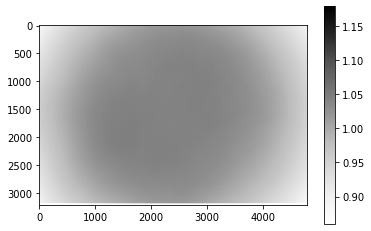

In [14]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(MASTER_FLAT["data"], sigma=3.0)

plt.imshow(MASTER_FLAT["data"], cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [15]:
additive_corr = MASTER_DARK["data"] #-MASTER_BIAS["data"]

sc_hdu = fits.open(fits_sci_image)[0]
try:
    RED_SCIENCE = (sc_hdu.data - additive_corr) / MASTER_FLAT["data"]
except ValueError:
    RED_SCIENCE = (np.transpose(sc_hdu.data) - additive_corr) / MASTER_FLAT["data"]

# Clean bad pixels
smoothed = median_filter(RED_SCIENCE, size=(5,5))

# Hot pixels
try:
    hot_pixel = np.where( HOT_PIXELS["data"]==1 )
    RED_SCIENCE[hot_pixel] = smoothed[hot_pixel]
except:
    print('Cannot clean hot pixels')

# Dead pixels
try:
    dead_pixel = np.where( DEAD_PIXELS["data"]==1 )
    RED_SCIENCE[dead_pixel] = smoothed[dead_pixel]
except:
    print('Cannot clean dead pixels')

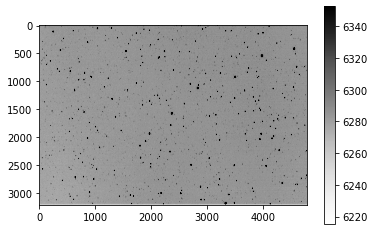

In [16]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(sc_hdu.data, sigma=3.0)

plt.imshow(sc_hdu.data, cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

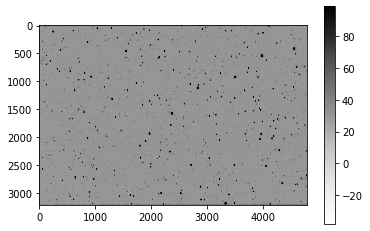

In [17]:
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(RED_SCIENCE, sigma=3.0)

plt.imshow(RED_SCIENCE, cmap='Greys', vmin=bkg_median-5*bkg_sigma, vmax=bkg_median+5*bkg_sigma)
plt.colorbar()

In [18]:
# Write appropriate FITS files
new_fn = f"{sc_im_name}_REDUCED{sc_im_ext}"
red_hdu = sc_hdu.copy()
red_hdu.data = RED_SCIENCE
red_hdu.header["PROCTYPE"] = "RED     "
red_hdu.header["FILENAME"] = new_fn
red_hdu.header["CREATOR"] = "JOCHEVAL"
red_hdu.header["MDARK"] = MASTER_DARK["path"]
red_hdu.header["MFLAT"] = MASTER_FLAT["path"]
red_hdu.header["HPIXELS"] = HOT_PIXELS["path"]
red_hdu.header["DPIXELS"] = DEAD_PIXELS["path"]

redim_dir = os.path.join(os.path.abspath(sc_im_dir), 'REDUCED')
if not os.path.isdir(redim_dir) : os.makedirs(redim_dir)
write_path = os.path.join(redim_dir, new_fn)
red_hdu.writeto(write_path, overwrite=True)
print(f"Calibrated image written to {write_path}.")

dic_to_return = {"path": write_path, "data": RED_SCIENCE,\
                 "MASTER DARK": MASTER_DARK,\
                 "MASTER FLAT": MASTER_FLAT,\
                 "HOT PIXELS": HOT_PIXELS,\
                 "DEAD PIXELS": DEAD_PIXELS\
                }

Calibrated image written to /home/etudiant/Documents/Archives_C2PU/Photometry/Asteroids/2023-11-14_OMICRON_F3p17_OPF_QHY600Ma_9-Metis/REDUCED/9-Metis_20231115T011656474_SC__0000s300_000000_REDUCED.fits.


# Photometry

In [19]:
#fits_sci_image = os.path.join('TD_Photometry_python', 'data', 'test_image.fits')
#fits_sci_image = os.path.abspath(fits_sci_image)

fits_sci_image = dic_to_return["path"]
sources = photometry.detect_sources(fits_sci_image)

Number of sources detected: 955


In [20]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,9.410161486115454,1.7659652103423975,0.25267680993968805,-0.33914716409222817,0.12853720336940394,25,0.0,82.82105055881225,1.0452906350190654,-0.04809264869181289
2,4585.017003671782,1.5844964812528697,0.2821921434005274,0.8550258663697832,-0.009588690890046794,25,0.0,50.499516529505875,1.0514987649495113,-0.054521917292114364
3,4659.902434889784,1.353037054095703,0.9730707826549282,-0.23887571209308966,-0.35698361354248276,25,0.0,111.39878952228291,1.046296831487473,-0.04913727535612325
4,2892.5500887182793,7.525857261842367,0.36843576802420713,-0.32523192583990945,-0.29131699138938993,25,0.0,242.7854980860558,1.3735527686775069,-0.3446133716325174
5,117.06555255999669,8.877804466007204,0.3743204275003378,0.1109748659118371,-0.03973721978057097,25,0.0,1414.581955595591,9.61438195756951,-2.4573034291730766
6,2855.0632946131527,9.34668900285054,0.39471531041162067,-0.0026726534495820657,-0.34395440733184995,25,0.0,513.0001440356481,3.4219207894427344,-1.335674880702593
...,...,...,...,...,...,...,...,...,...,...
949,4102.5859808042405,3208.929155570938,0.2865353355835999,-0.6648318018758772,-0.6751090008722143,25,0.0,68.28376714233934,1.142855311468538,-0.14497812758852377
950,4250.929664384973,3209.1459339455323,0.3434162637506664,-0.8245217854951156,-0.43635954103577296,25,0.0,76.02048768906536,1.809020822043906,-0.6436089141737572


In [21]:
fwhm = photometry.get_fwhm(fits_sci_image, sources)

the DATE-REF keyword is non-standard. [astropy.wcs.wcs]
the DATE-REF keyword is non-standard. [astropy.wcs.wcs]


In [22]:
phot_table = photometry.apert_photometry(fits_sci_image, sources, fwhm)

In [23]:
phot_table

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub,noise,SNR
,pix,pix,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,9.410161486115454,1.7659652103423975,1578.4623732210227,19.354146134370833,420.687864254073,1157.7745089669497,39.72986752080886,29.141162083174713
2,4585.017003671782,1.5844964812528697,667.0434708658278,15.329833307450052,333.21412315004005,333.8293477157877,25.82718472590127,12.92550276999416
3,4659.902434889784,1.353037054095703,702.7882261804103,20.896009063275887,454.20228633346807,248.58593984694227,26.51015326587929,9.377008776742626
4,2892.5500887182793,7.525857261842367,4515.923367882198,62.8129436548788,1365.322082938866,3150.6012849433323,67.20062029387972,46.883514931338695
5,117.06555255999669,8.877804466007204,26392.179149815234,189.05705077920095,4109.404070956777,22282.775078858456,162.4566993072777,137.1613185167073
6,2855.0632946131527,9.34668900285054,9327.654941399145,92.63643417838367,2013.5749402764397,7314.080001122706,96.5797853662926,75.73096143652644
...,...,...,...,...,...,...,...,...
950,4250.929664384973,3209.1459339455323,566.884590234951,15.196939299800919,330.325496813237,236.559093421714,23.809338298973177,9.935559336057485


In [24]:
phot_sso_table = photometry.query_sso_photometry(fits_sci_image, fwhm)

the DATE-REF keyword is non-standard. [astropy.wcs.wcs]


Number of SSOs predicted: 29


In [25]:
phot_sso_table

id,xcenter,ycenter,sky_center,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub,noise,SNR
,pix,pix,"deg,deg",,,,,,
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64
1,2394.6202680318197,1599.5599299441856,"97.73776791666666,24.63672083333333",845.8426935082773,37.552722586456085,816.2578990641408,29.58479444413649,29.083374864487052,1.0172407632190483
3,2932.7244881722445,1639.314205805843,"97.81433708333331,24.625396666666667",694.7913418759616,31.694920854572043,688.9308610898966,5.860480786065068,26.358894928960158,0.22233408501606938
4,1963.7475253239245,1082.1240560096126,"97.68250458333333,24.708985555555554",674.4082600813294,28.99694294595443,630.2867568085215,44.1215032728079,25.969371576557826,1.6989823239556454
5,3112.8321737238193,1815.85669540292,"97.83789999999999,24.600346666666667",963.1356496793218,33.6735406040535,731.9387680676199,231.19688161170188,31.034426846315718,7.449690717879284
7,1720.4064514442548,1095.3224596769232,"97.64746375,24.710021944444442",708.7526394552783,30.745057463989205,668.284328902781,40.468310552497314,26.622408596054534,1.5200844959796296
9,1951.8155887307498,864.1578931176001,"97.683515,24.737499722222225",769.4711610577456,31.75170085825947,690.1650492745761,79.30611178316951,27.739343198023732,2.8589758314400036
...,...,...,...,...,...,...,...,...,...
19,1440.5515970651231,609.2408143753162,"97.61338416666666,24.77647",621.943887141347,28.303571532519577,615.2154156587965,6.728471482550503,24.938802840981502,0.26979929732207203
